In [1]:
using DIVAnd
using PyPlot
using Statistics

## Function to interpolate

In [2]:
fun(x,y) = sin.(6x) * cos.(6y)

# observations

x = rand(1);
y = rand(1);
f = fun.(x,y)

# final grid
xi,yi = ndgrid(range(0,stop=100,length=100), range(0,stop=110,length=110));

# reference field
fref = fun.(xi,yi);

### Simple plot

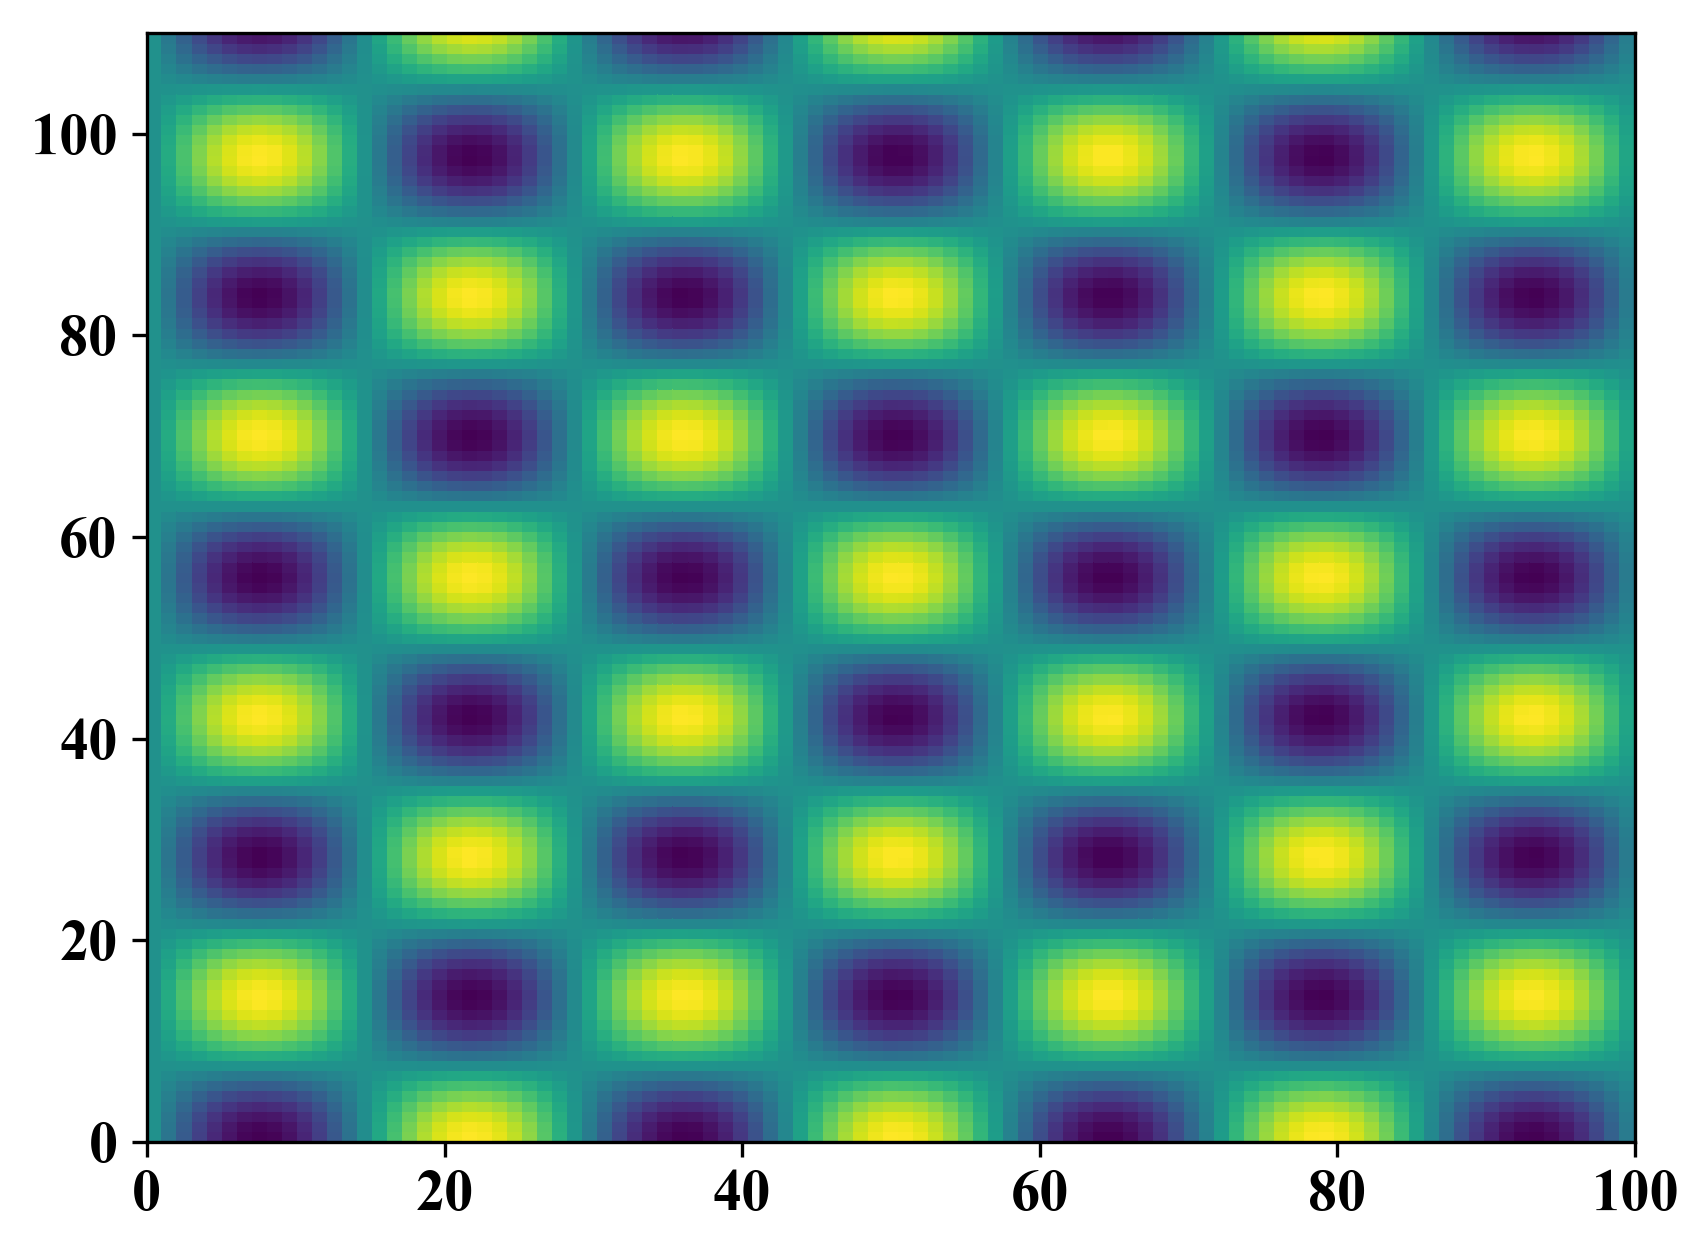

PyObject <matplotlib.collections.QuadMesh object at 0x7f03bcc6c810>

In [3]:
PyPlot.pcolormesh(xi, yi, fref)

## Create mask

In [4]:
mask = trues(size(xi));

# Add false along the edges
mask[1,:] .= false;
mask[end,:] .= false;
mask[:,1] .= false;
mask[:,end] .= false;

# island
mask[30:80,30:80] .= false;

### Simple plot
Note the *false* along the borders.

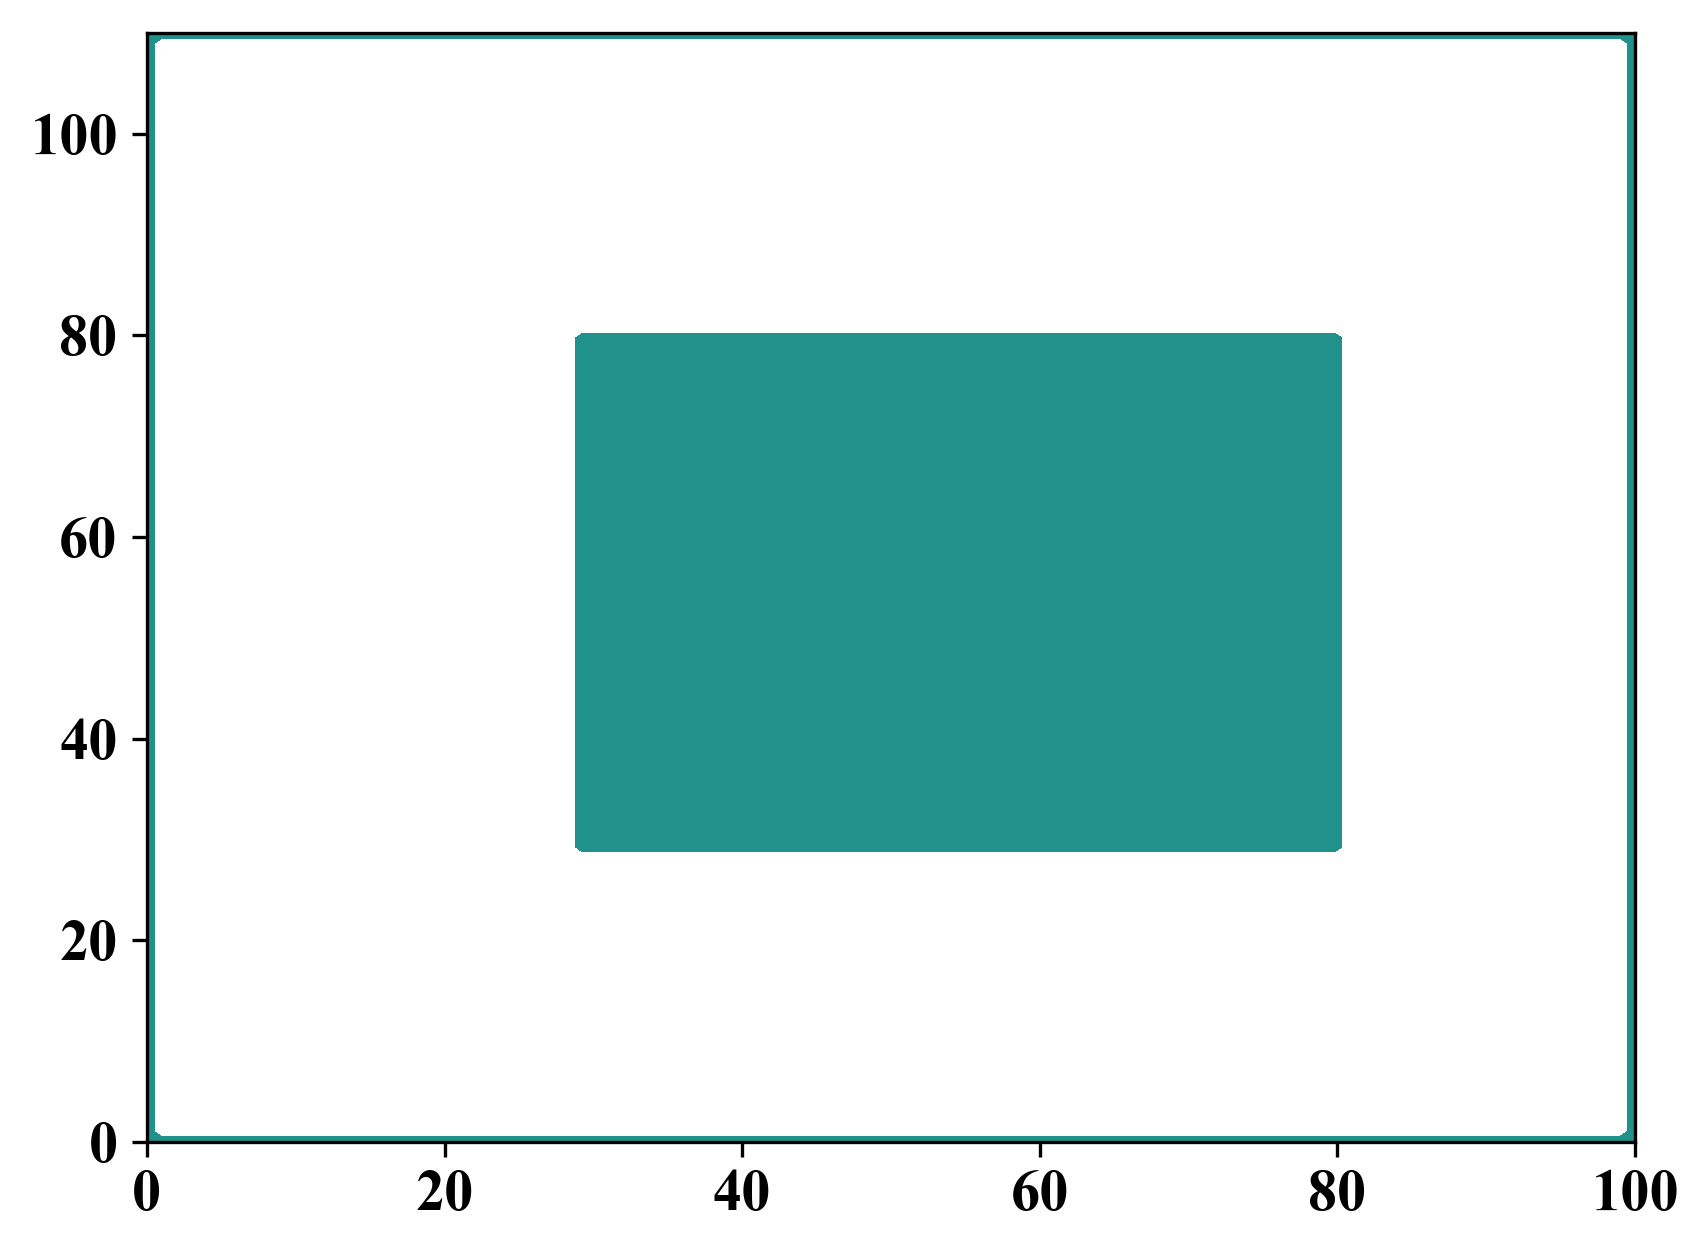

PyObject <matplotlib.contour.QuadContourSet object at 0x7f03bb94bed0>

In [5]:
PyPlot.contourf(xi, yi, mask, [-.5, .5])

## Parameters

In [6]:
# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

# correlation length
len = 10;

# obs. error variance normalized by the background error variance
epsilon2 = 10000000.;

### Advection along isobaths
*h* is the artificial topography, it has the same size as the computation grid 

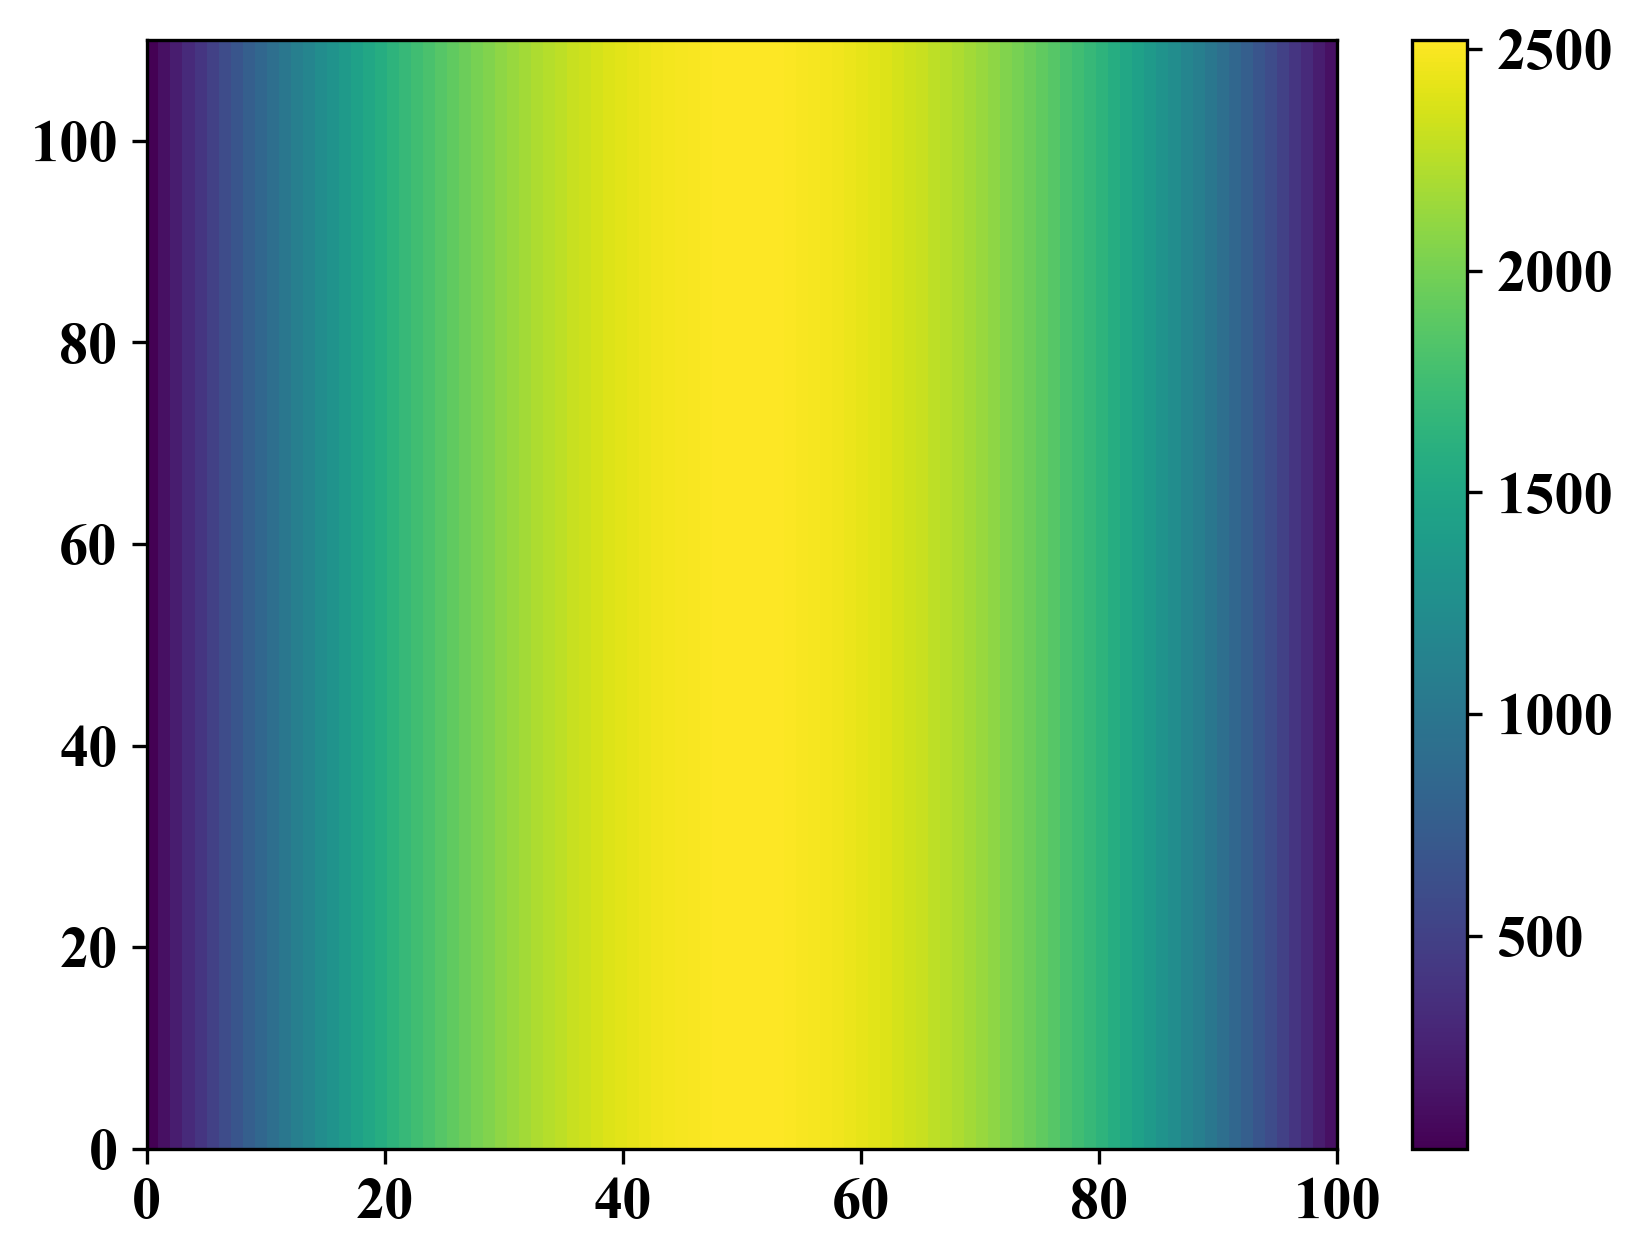

┌ Info: (100, 110)
└ @ Main In[7]:2


PyObject <matplotlib.colorbar.Colorbar object at 0x7f03bb8e4510>

In [7]:
h = xi .* (100 .- xi) .+ 20;
@info(size(h))
PyPlot.pcolormesh(xi, yi, h)
PyPlot.colorbar()

### Advection through velocity field
We define the 2 components of the velocity field field.     
*rfluxes* specifies the error variance on the constraint.    

In [8]:
fluxes1 = sin.(yi[1,:]./10.)+0.1*rand(size(h)[2])
fluxes2 = sin.(xi[:,1]./10.)+0.1*rand(size(h)[1])
rfluxes = 1;

In [9]:
@info(size(fluxes1))
@info(size(fluxes2));

┌ Info: (110,)
└ @ Main In[9]:1
┌ Info: (100,)
└ @ Main In[9]:2


## Analysis
The first arguments of `DIVAndrun` are the same as a classical analysis.     
Then we add:
* *topographyforfluxes*: a tuple of 2 elements, one for each horizontal component, for the advection along isobath.
* *fluxes*: a tuple of 2 elements storing the pseuso-velocity field.
* *epsfluxes*: a scalar defining the error variance on the constraint. 

In [10]:
@time fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;
    topographyforfluxes=(h,0),fluxes=(fluxes1,0),epsfluxes=rfluxes,alphabc=1,alpha=[1, 0, 1]);

 19.773205 seconds (43.19 M allocations: 2.597 GiB, 6.30% gc time)


## Create plots

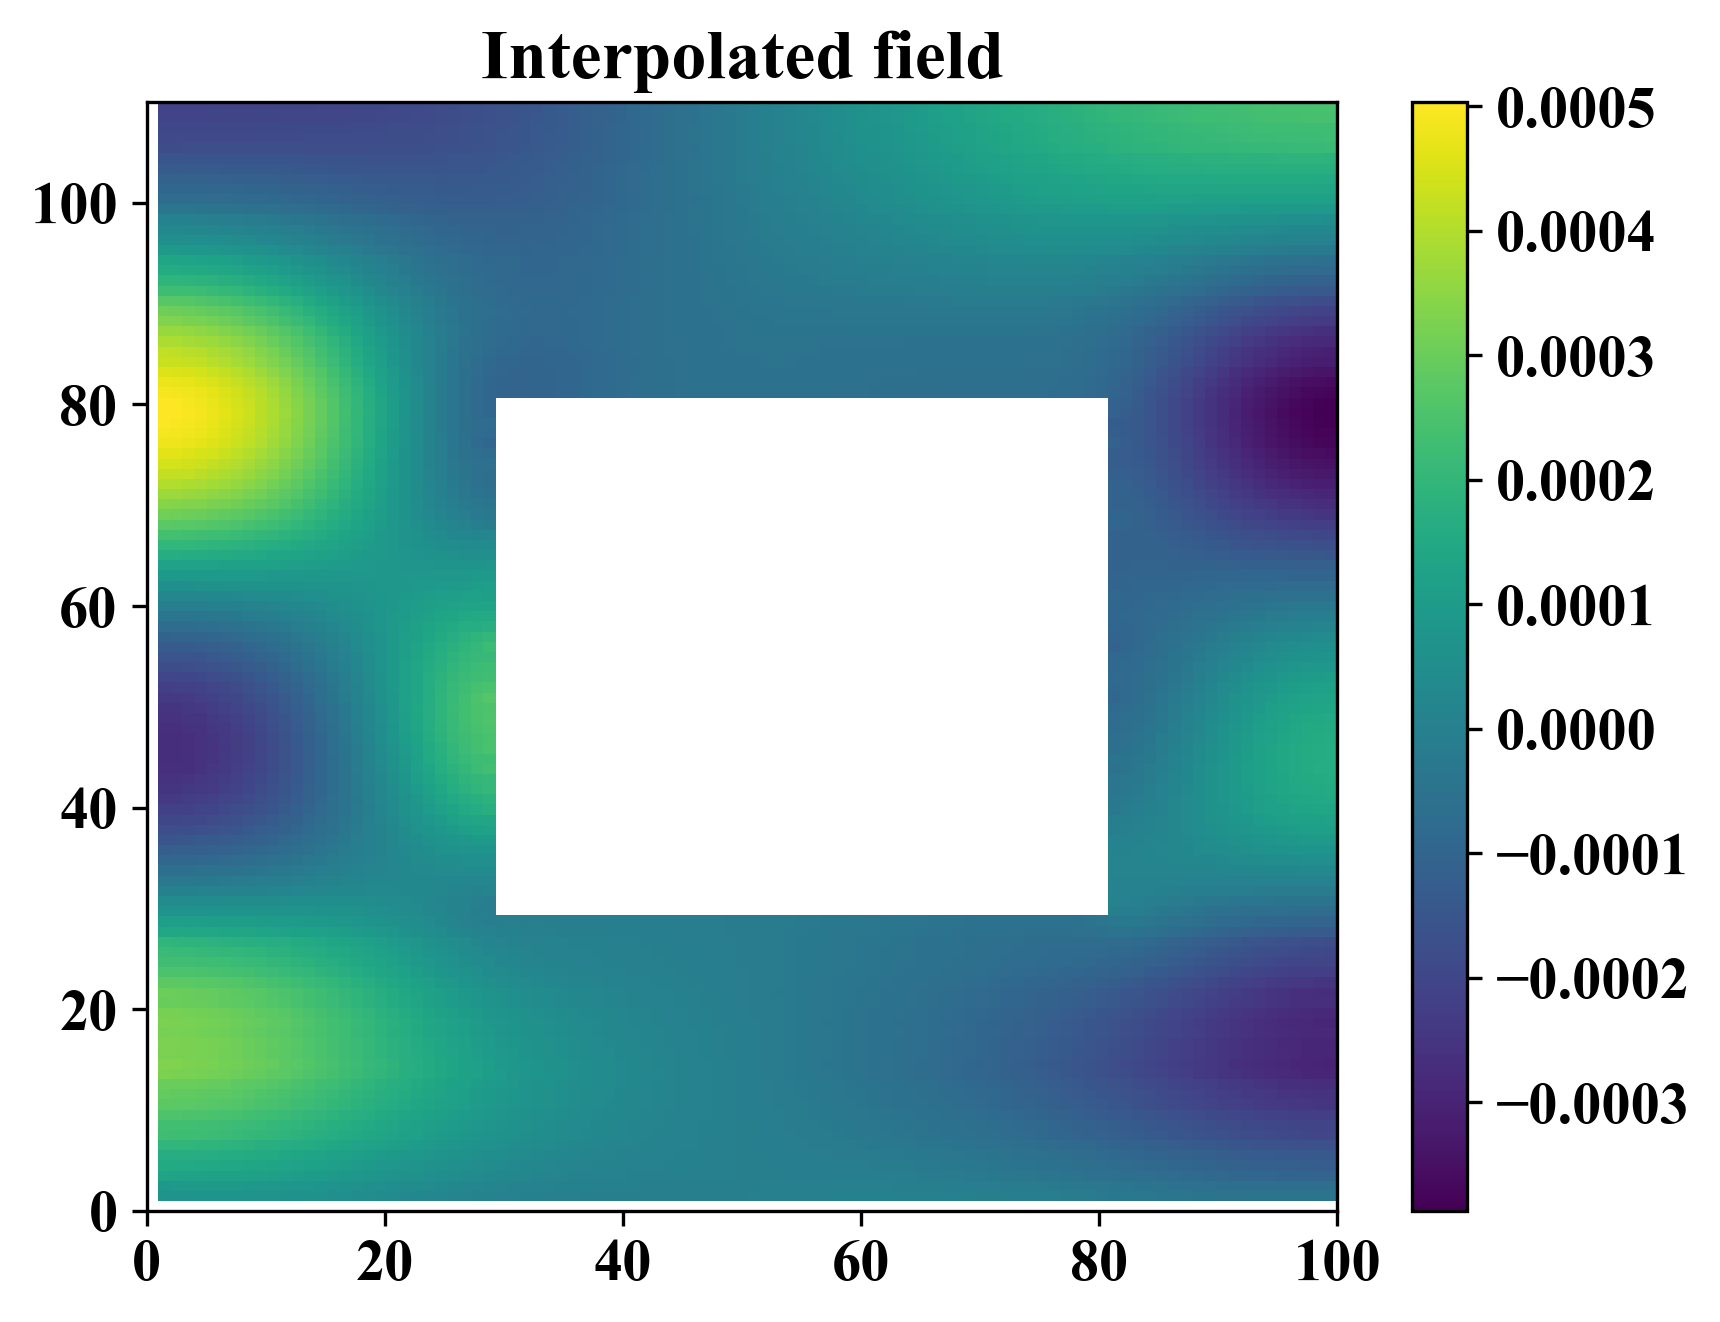

In [11]:
figure() 
pcolor(xi,yi,fi);
colorbar()
title("Interpolated field");
show()
savefig("DIVAnd_simple_example_fluxes1.png")

In [12]:
fluxesafter=zeros(size(h)[2])

for j=1:size(h)[2]
 for i=2:size(h)[1]-2
	if mask[i,j]&& mask[i+1,j]
 		fluxesafter[j]=fluxesafter[j]+h[i,j]*(fi[i+1,j]-fi[i,j])
	end
 end
end
@show var(fluxes1+fluxesafter)
@show var(fluxes1)

@time fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;
    topographyforfluxes=(0,h),fluxes=(0,fluxes2),epsfluxes=rfluxes,alphabc=1,alpha=[1, 0, 1]);

var(fluxes1 + fluxesafter) = 0.00755744897767216
var(fluxes1) = 0.498318673869058
  0.634747 seconds (1.29 M allocations: 461.440 MiB, 6.47% gc time)


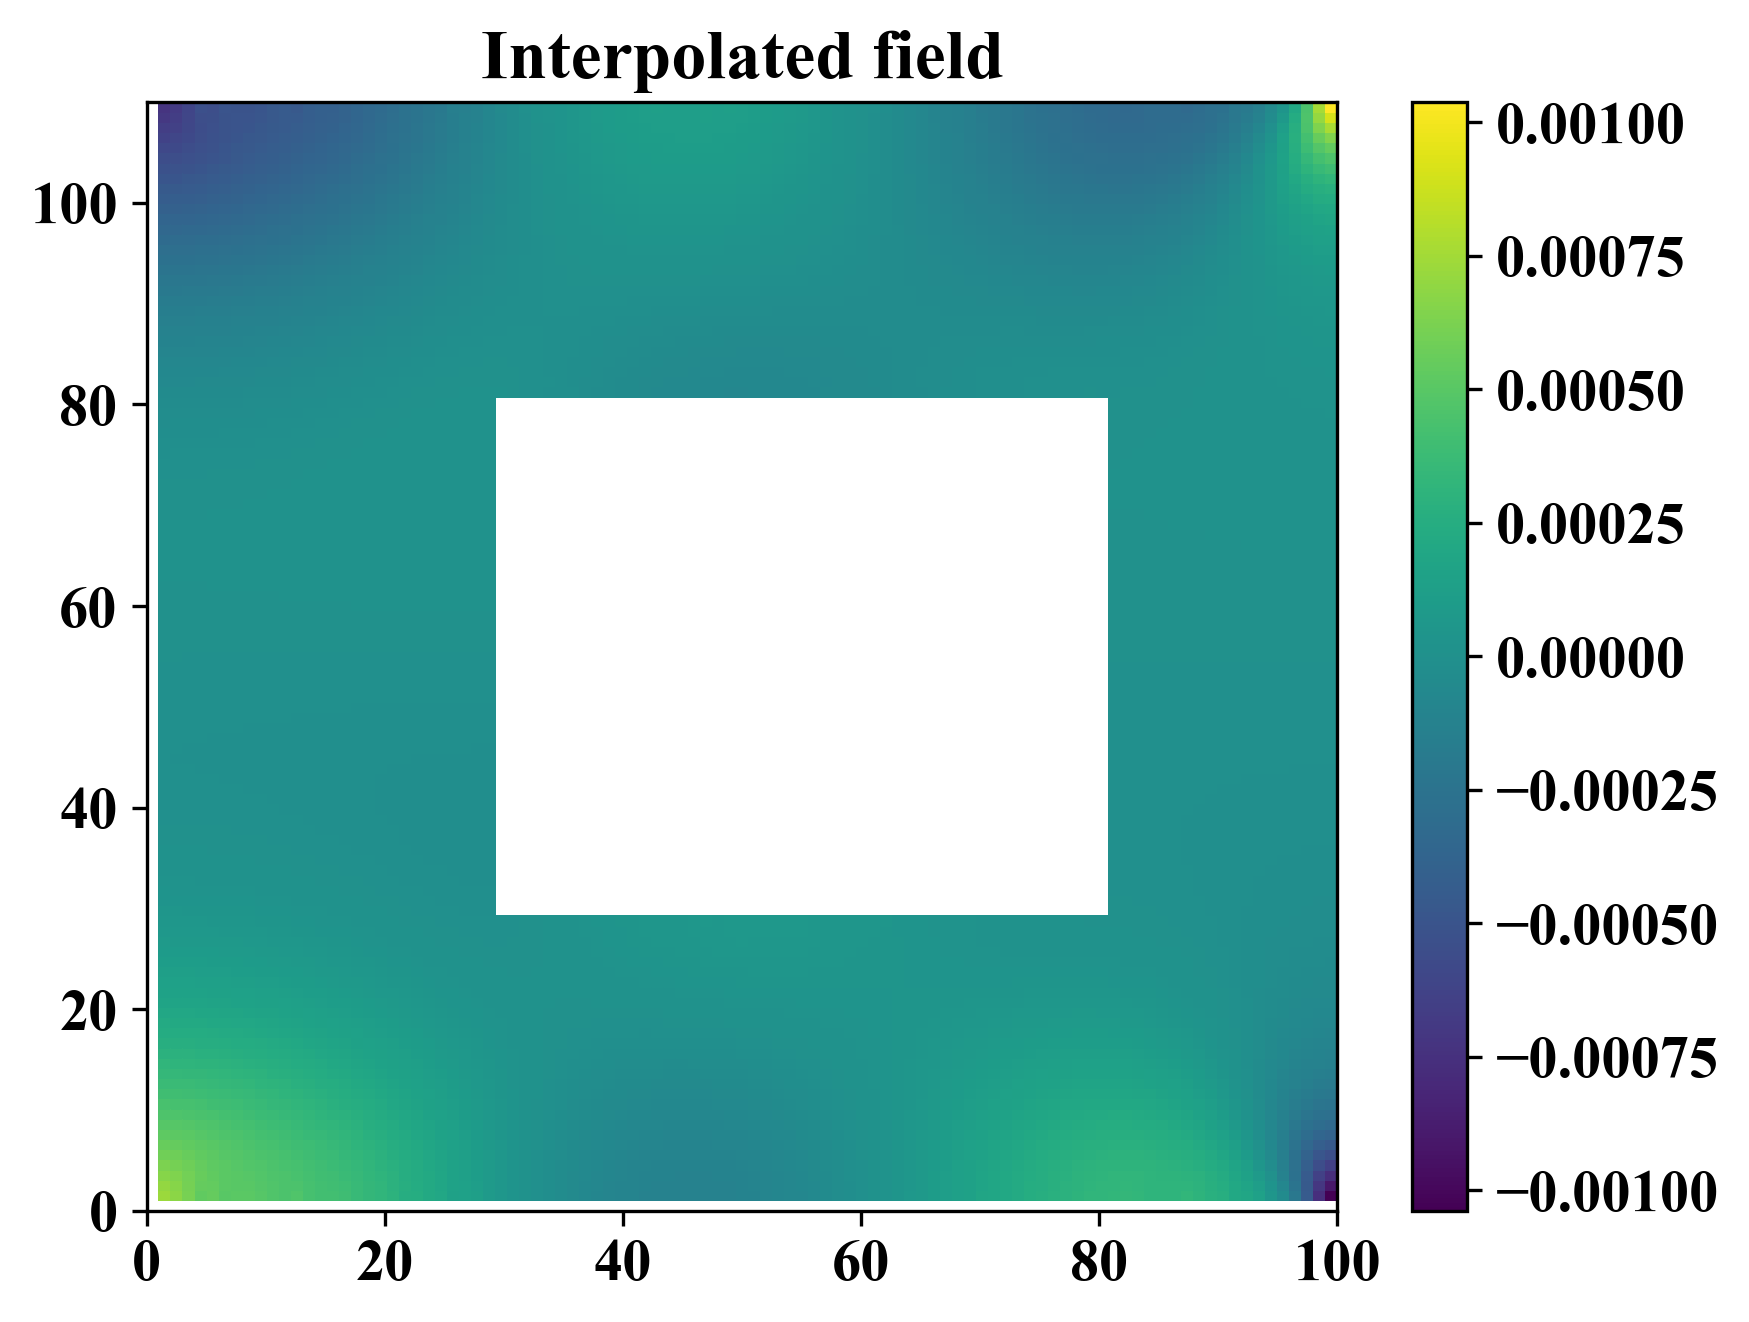

In [13]:
figure()
pcolor(xi,yi,fi);
colorbar()
title("Interpolated field");
show()
savefig("DIVAnd_simple_example_fluxes2.png")

In [14]:
fluxesafter=zeros(size(h)[1])

for i=1:size(h)[1]
 for j=2:size(h)[2]-2
	if mask[i,j]&& mask[i,j+1]
 		fluxesafter[i]=fluxesafter[i]+h[i,j]*(fi[i,j+1]-fi[i,j])
	end
 end
end
 
@show var(fluxes2+fluxesafter)
@show var(fluxes2)

# finally both directions
@time fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;
    topographyforfluxes=(h,h),fluxes=(fluxes1,fluxes2),epsfluxes=rfluxes,alphabc=1,alpha=[1, 0, 1]);

var(fluxes2 + fluxesafter) = 0.0026164507430116403
var(fluxes2) = 0.44634017975745727
  1.110698 seconds (1.28 M allocations: 875.954 MiB, 24.77% gc time)


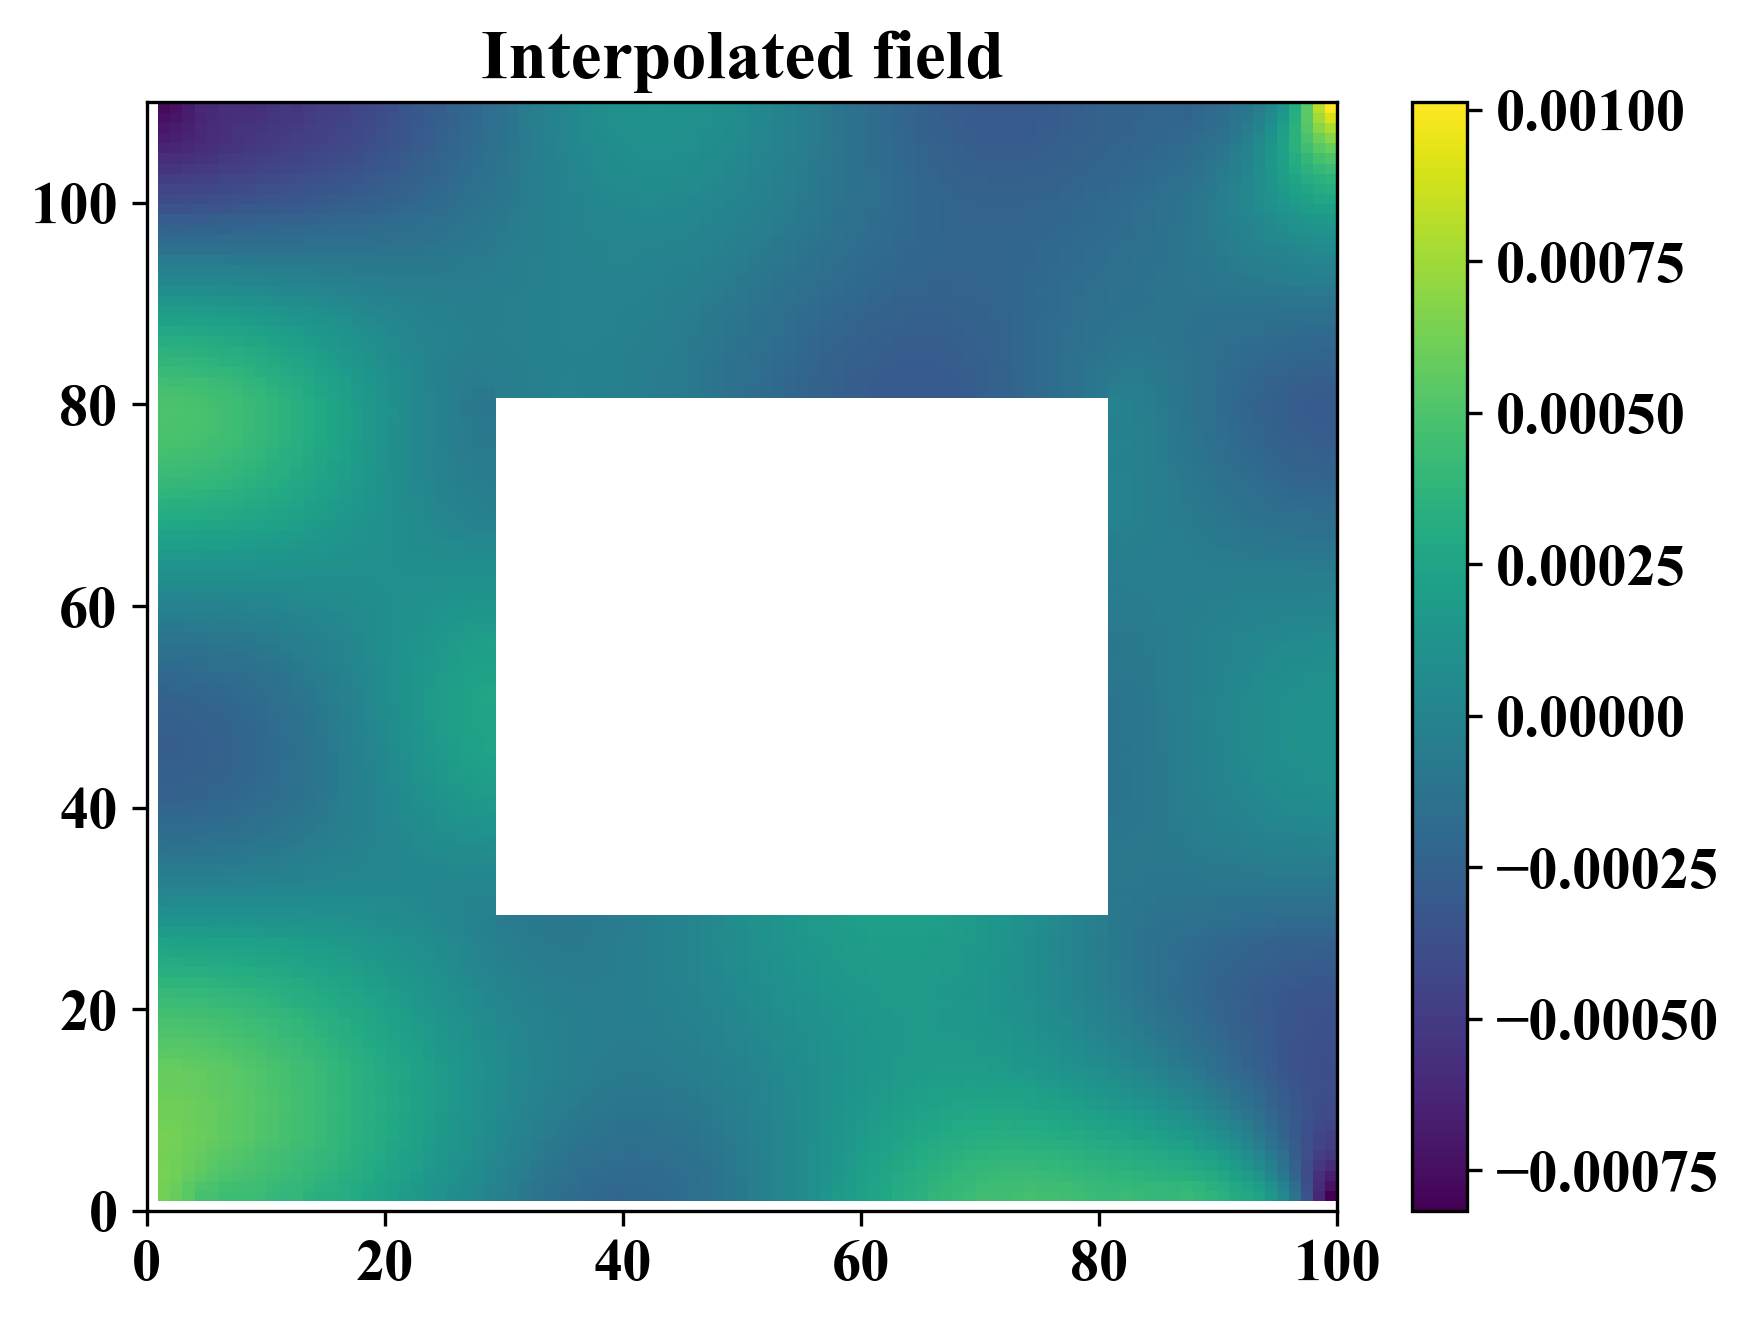

In [15]:
figure()
pcolor(xi,yi,fi);
colorbar()
title("Interpolated field");
show()
savefig("DIVAnd_simple_example_fluxes12.png")

In [16]:
fluxesafter=zeros(size(h)[2])

for j=1:size(h)[2]
 for i=2:size(h)[1]-2
	if mask[i,j]&& mask[i+1,j]
 		fluxesafter[j]=fluxesafter[j]+h[i,j]*(fi[i+1,j]-fi[i,j])
	end
 end
end
@show var(fluxes1+fluxesafter)
@show var(fluxes1)

fluxesafter=zeros(size(h)[1])

for i=1:size(h)[1]
 for j=2:size(h)[2]-2
	if mask[i,j]&& mask[i,j+1]
 		fluxesafter[i]=fluxesafter[i]+h[i,j]*(fi[i,j+1]-fi[i,j])
	end
 end
end
 
@show var(fluxes2+fluxesafter)
@show var(fluxes2);

var(fluxes1 + fluxesafter) = 0.007647568477316004
var(fluxes1) = 0.498318673869058
var(fluxes2 + fluxesafter) = 0.0027102792331702144
var(fluxes2) = 0.44634017975745727
